# Module 5 Final Project Submission

Please fill out:
* Student name: Fernando Aguilar Islas
* Student pace: Part-time
* Scheduled project review date/time: Friday, August 23, 2019 @ 14:00 EST
* Instructor name: Brandon Lewis
* Blog post URL: http://tiny.cc/Mod5_Aguilar_blog
* Video Walkthrough: http://tiny.cc/Mod5_Aguilar_walkthrough


## 1. Introduction
For this project I will use the Online Shoppers Purchasing Intention Dataset which contains information about website visitors and their behaviour on the site. This dataset tracks the user as revenue generating or not. The aim of this project is to build a model that can accurately calssify a user as revenue generating or not given his behavior when visiting the website. Having an efficient model is imperative, since it will be tracking the users' behaviour in real time to predict if the session will generate revenue. With the use of this predictive model, a marketing startegy could be deployed in order to induce the user to generate revenue or to incentivise revenue generating behaviour during the session.

### 1.1 Framework
Throughout the project I will be using the OSEMiN framework, wich stands for Obtain, Scrub, Explore, Model and Interpret. I will proceed in the following way:
+ Obtain: The dataset consists of feature vectors belonging to 12,330 sessions and was downloaded from the UCI Machine Learning Repository.
+ Scrub: I will search for null values and outliers to replace them with more suitable values or delete them form the data set. I will also loo at multicollinearity issues amongst the features and find creative ways to deal with them.
+ Explore: Throughout the whole process, it is important to lookout for other important information that can be gathered from the data. I will carry out Exploratory Data Analysis and answer relevant questions about the current state of business.
+ Model: I will use single and ensemble binary classification models. The aim of the project is to select the best performing model and fine-tune its hyperparameters to achieve correct identification of revenue generating sessions.
+ Interpret: Interpret the results of the models to make recommendations that generate value.

## 2. Import Required Libraries

In [1]:
# EDA tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
import warnings
warnings.filterwarnings("ignore")

#Single model classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#Ensemble classifications models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report, roc_auc_score,
f1_score, recall_score, precision_score, SCORERS)
import time

# Imbalance, Hyperparameter tunning and pipelines
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


### 2.1 Helper Functions

In [2]:
def distbox_plot(data):
    '''Function to plot a seaborn distribution plot 
        with a box plot on top.
        Reference: https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/'''
    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(14,4),gridspec_kw={"height_ratios": (.15, .85)})
    # Add a graph in each part
    sns.boxplot(data, ax=ax_box)
    sns.distplot(data, ax=ax_hist)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    #Print describtive statistics
    print(data.describe())

def baseline_models(data=[], verbose=False):
    #List of models to be used
    models=[DecisionTreeClassifier(),LogisticRegression(),
            RandomForestClassifier(),GradientBoostingClassifier()]
    #Create training and testing data sets depending on wheather or not they have been generated previously.
    if len(data)== 2:
        X_train, X_test, y_train, y_test = train_test_split(data[0],data[1],random_state=123)
    else:
        X_train, X_test, y_train, y_test = data[0],data[1],data[2],data[3]
    #Instantiate lists to store each of the models results
    accuracy = []
    f1 = []
    auc = []
    recall = []
    precision = []
    #Run thorugh each of the models to get their performance metrics
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1.append(f1_score(y_test, test_preds))
        accuracy.append(accuracy_score(y_test, test_preds))
        auc.append(roc_auc_score(y_test, test_preds))
        recall.append(recall_score(y_test, test_preds))
        precision.append(precision_score(y_test, test_preds))
        #Print the model and its report
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
    #store results in dataframe
    results = pd.DataFrame([f1,auc, accuracy, precision,recall],
                      index= ['f1','roc_auc','accuracy','precision','recall',],
                           columns=['DecisionTree','LogisticRegression','RandomForest','Gradient Boosting'])
    #Change orientation of the dataframe
    return results.transpose()

def plot_feat_importance(clf,index):
    '''Plot the 0 most important features for a classifier model in a bar chart
    according to importance'''
    feat_importances = pd.DataFrame(clf.feature_importances_, index=index, columns=['Score'])
    feat_importances = feat_importances.sort_values(by='Score',ascending=True).tail(10)
    feat_importances.plot(kind='barh', title='Top 10 Important Features',legend=False)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show();
    
def heatmap(data,figsize=(8,8), annot=False):
    #plot heatmap to find multicollinearity
    plt.figure(figsize=figsize)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    sns.heatmap(data.corr(),vmin=-0.75,vmax=0.75,center=0, cmap=cmap,annot=annot);

def grid_pipe(pipedict, hyperdict, scoring='accuracy', display=True):
    model_scores=[]
    fitted_models={}
    for name, pipeline in pipedict.items():
    # Construct grid search
        model = GridSearchCV(estimator=pipeline,
                             param_grid=hyperdict[name],
                             scoring=scoring,
                             cv=5, verbose=2, n_jobs=-1, return_train_score = True)

        # Fit using grid search
        start = time.time()
        model.fit(X_trainres, y_trainres)
        end = time.time()
        #Append socres and time
        model_scores.append((name,model.best_score_,end-start))
        #Append model
        fitted_models[name]=model
        if display:
            #Print when the model has been fitted
            print(f'The {name} model has been fitted.')
            # Best accuracy
            print('Best accuracy: %.3f' % model.best_score_)
            # Best params
            print('Best params:\n', model.best_params_,'\n')
    
    return model_scores, fitted_models

In [153]:
  
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='k', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, .1]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, .1]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

## 3. Exploratory Data Analysis


In [4]:
#Load the file into a pandas data frame.
data = pd.read_csv("online_shoppers_intention.csv")
#Get structural information of the data set.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes: bool(

The dataset contains 18 columns, a total of which 17 are features and 1 is the target variable, in this instance, 'Revenue'. Below is a description of what each column means in the dataset:

* Administrative: Number of 'administrative' pages viewed
* Administrative_Duration: Time spent looking at 'administrative' pages
* Informational: Number of 'informational' pages viewed
* Informational_Duration: Time spent looking at 'informational' pages
* ProductRelated: Number of 'product related' pages viewed
* ProductRelated_Duration: Time spent looking at 'product related' pages
* BounceRates: The percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session
* ExitRates: It is calculated as for all pageviews to the page, the percentage that were the last in the session
* PageValues: Represents the average value for a web page that a user visited before completing an e-commerce transaction
* SpecialDay: Indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction
* Month: Month of the year for the session
* OperatingSystems: Operating system used for the session
* Browser: Browser used for the session
* Region: Region of the user
* TrafficType: Traffic Type
* VisitorType: Types of Visitor
* Weekend: Session occured on a weekend or not
* RevenueRevenue: Represents whether the user generated reveue or not

It looks like the data contains numerical and non-numerical variables. Let's look at the first few rows of the dataset.


In [5]:
#Visualize first 5 rows of data of the first 9 columns.
data.head().iloc[:,:9]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0


In [6]:
#Visualize first 5 rows of data of the remaining columns.
data.head().iloc[:,9:]

,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


From this first inspection at the data contained in the dataset, some of the numerical features are actually categorical such as OperatingSystems, Browser, and Region, to name a few. Before doing feature engineering, i will first look for missing or dummy values in the data and outliers.

In [7]:
#Look for missing values.
data.isna().any()

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool

The dataset does not contain any missing values. Let's have a deeper look at the numerical variables in the dataset. I will start by getting the descriptive statistics of the numerical features. Next, I will look at the histograms and lastly I will inspect boxplots.

In [8]:
data.describe().iloc[:,:8]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000


In [9]:
data.describe().iloc[:,8:]

,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


The numerical features in the data set are made up off continuous, discrete and categorical variables. Another observation is that most of the variables have a minimum value of zero, meaning that probably they are zero-inflated variables which are skwed to the right. I will look at the unique number of values in each of the varibles with discrete values, to divide them into numeric or categorical variables.

In [10]:
#Get number of unique values for each discrete variable in the dataset.
for col in data.describe().columns:
    if data[col].dtype == int:
        print(f'{col}:', data[col].nunique())

Administrative: 27
Informational: 17
ProductRelated: 311
OperatingSystems: 8
Browser: 13
Region: 9
TrafficType: 20


With this information I will use the Administrative, Informational, and ProductRelated as discrete variables since each of the values represent the amount of pages per category the user viewed during the session. I will use OperatingSystems, Browser, region, and TrafficType as categorical variables since there is not a numerical relationship amongts the different values, but they are label encoded to differentiate amongst operating system, and browser used by the user, his geographic region, and how the user got the site. I will gather more insight by looking at the histograms.

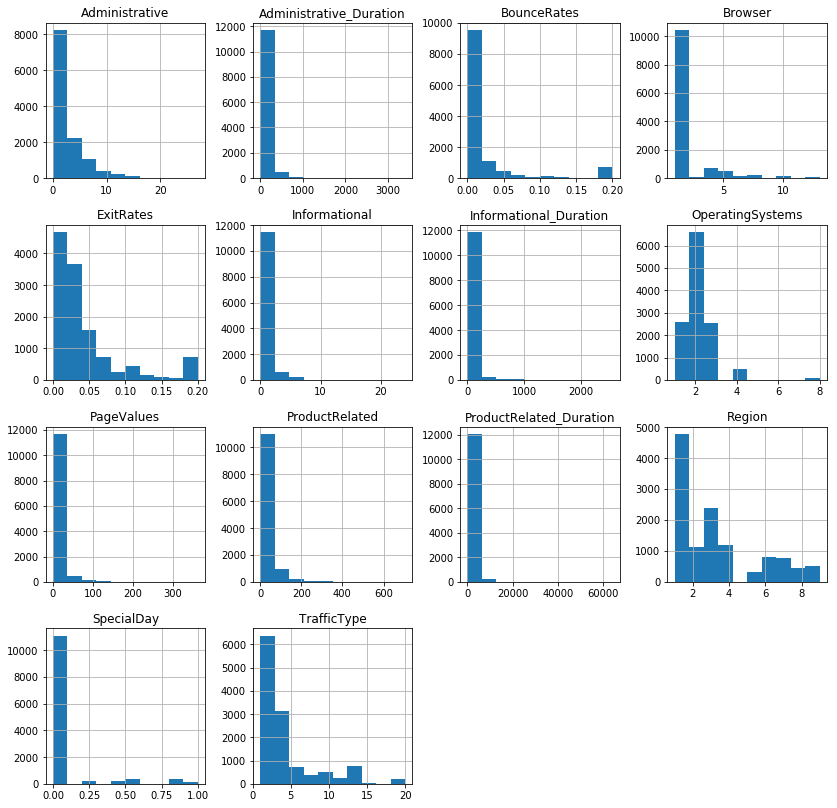

In [11]:
data[data.describe().columns].hist(figsize=(14,14));

None of the features is normally distributed, since they are highly skewed to the right, most distributions seem to follow a lognormal distribution. Initially, the one variable that catches my attention is SpeciaDay. Althoug it apparently seems like a continuous varibale, I believe it could actually be considered as either a binary or categorical feature. Let's look closer at its content.

In [12]:
#Get value counts for SpecialDay
data.SpecialDay.value_counts()

0.0    11079
0.6      351
0.8      325
0.4      243
0.2      178
1.0      154
Name: SpecialDay, dtype: int64

This variable would be better considered as categorical since it has only 6 values and eventhough they are numerical, they are not numerically relationable amongts each other. The lowest value of zero means that the date when the user accessed the webstie is not a special day or even close to it, the value increases as it gets closer the the special day. The highest value of 1 means the user visited the website on a special day. Special day refers to holidays or special occassions such as Mother's Day, Valentine's Day, etc.

Now I will look at the non-numerical variables in the dataset.

In [13]:
#Get non-numerical features.
non_num_cols = list(set(data.columns) - set(data.describe().columns))
print('Non-numerical features: ',non_num_cols)

Non-numerical features:  ['VisitorType', 'Revenue', 'Weekend', 'Month']


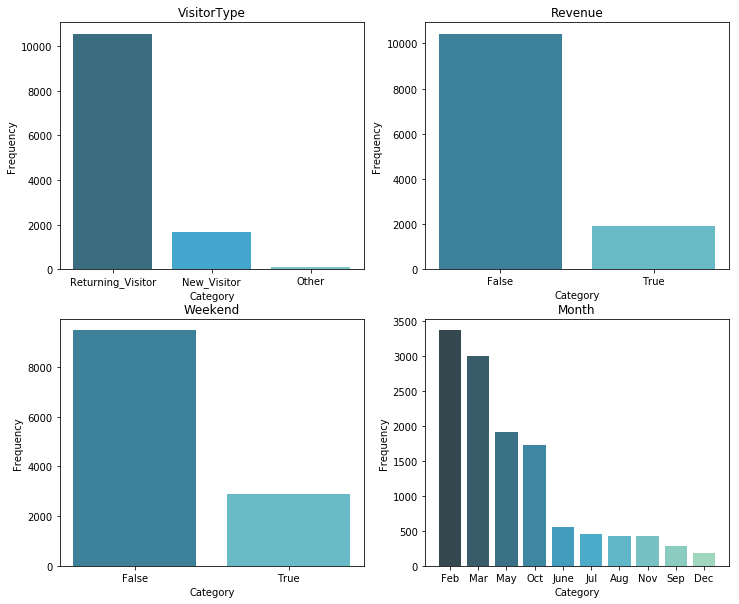

In [14]:
#Instantiate a 2x2 figure for the 4 plots.
fig, axs = plt.subplots(2, 2,figsize=(12,10))
#Create a bar chart for each of the non-numerical variables.
for i, col in enumerate(non_num_cols):
    #Helper variables to assign the correct axes to each of the 4 plots.
    j=i//2
    k=i%2
    #Setting a color palette for the plots.
    color = sns.color_palette("GnBu_d",n_colors=len(data[col].unique()))
    #Create the bar plot.
    axs[j,k].bar(data[col].astype('str').unique(), data[col].value_counts(), color= color)
    axs[j,k].set_title(col)
    axs[j,k].set_ylabel('Frequency')
    axs[j,k].set_xlabel('Category')
plt.show();

The only feature that draws my attention amongst this non-numerical features is visitor-type, since it by definition be a binary variable. A user is either a returning visitor or a new one. There should not be other. Now, I will take a look at its frequency to decide weather to classify those 'other' visitor-types as new_visitor or to drop them if they are outliers.

In [15]:
print(data.VisitorType.value_counts(),'\n')
print('''Number of revenue generating users as VisitorType 'Other': ''',
      data[data['VisitorType']=='Other'][data['Revenue']==True].Revenue.count())

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64 

Number of revenue generating users as VisitorType 'Other':  16


Even though, the 'Other' category has a sample size of 85 which is very small compared to the whole data set, I will not delete it since some of the sessions resulted in revenue and might add knowledge to the model. Also, it is important to keep this category since the model will be dealing with this data in real time.

Another concern is that it appears that the incidence in the target variable shows the dataset might be imbalanced. Target incidence is defined as the number of cases of each individual target value in a dataset. Target incidence shows if  the dataset is  balanced or imbalanced. This is important since the aim of the project is to predict whether or not a user session generated revenue or not. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:
1. False(value:0) - The session did not generate revenue.
2. True (value:1) - The session generated revenue.

Let's look at the incidence for both outcomes.

False    84.53
True     15.47
Name: Revenue, dtype: float64


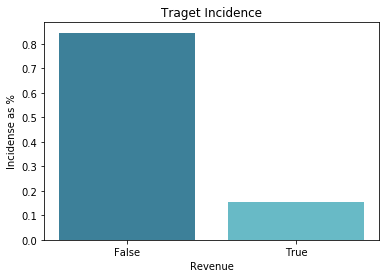

In [16]:
print(round(data.Revenue.value_counts(normalize=True),4)*100)
plt.bar(['False','True'], data.Revenue.value_counts(normalize=True), color=sns.color_palette("GnBu_d",n_colors=2))
plt.title('Traget Incidence')
plt.ylabel('Incidense as %')
plt.xlabel('Revenue')
plt.show();

A 15% target incidence considering the amount of data in the dataset could work, however the proportion is still very small and I consider it to be imbalanced. Hence, further on I will consider data augmentation techniques in order to boost the target incidence with synthetic data. Now I'm interested to see what regions provide the most revenue generating sessions and the most visitors to the site.

### 3.1 Visitors per Region

1    38.77
3    19.49
4     9.59
2     9.21
6     6.53
7     6.17
9     4.14
8     3.52
5     2.58
Name: Region, dtype: float64


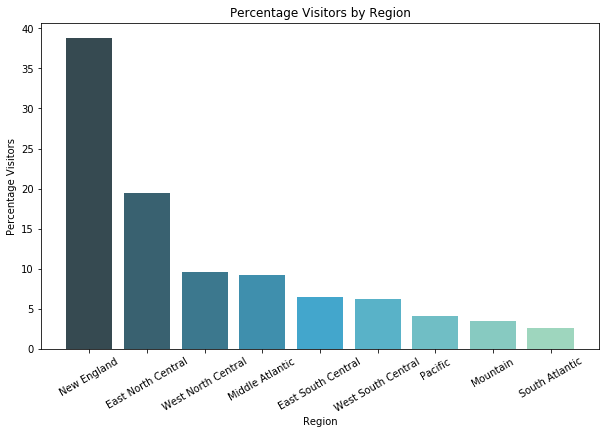

In [17]:
regional_revenue = data[['Region','Revenue']]
regional_revenue = regional_revenue.replace(to_replace=[1, 2,3,4,5,
                                                        6,7,8,9],value=['New England','Middle Atlantic',
                                                                        'East North Central',
                                                                        'West North Central','South Atlantic',
                                                                        'East South Central',
                                                                        'West South Central',
                                                                        'Mountain','Pacific'])
print(round(data.Region.value_counts(normalize=True),4)*100)
plt.figure(figsize=(10,6))
plt.bar(regional_revenue['Region'].value_counts(normalize=True).index, regional_revenue['Region'].value_counts(normalize=True)*100,
        color=sns.color_palette("GnBu_d",n_colors=9))
plt.xticks(rotation='30')
plt.xlabel('Region')
plt.ylabel('Percentage Visitors')
plt.title('Percentage Visitors by Region')
plt.show()

Most visitors come from New England region, and generally from the northeast. Advertising budget should be analyzed to be fairly allocated amongst the 9 defined market regions in the US. Moreover, market research should be carried out to explain the differences amongts the visitors generated by each of the regions.

### 3.2 Top Revenue Generating Regions

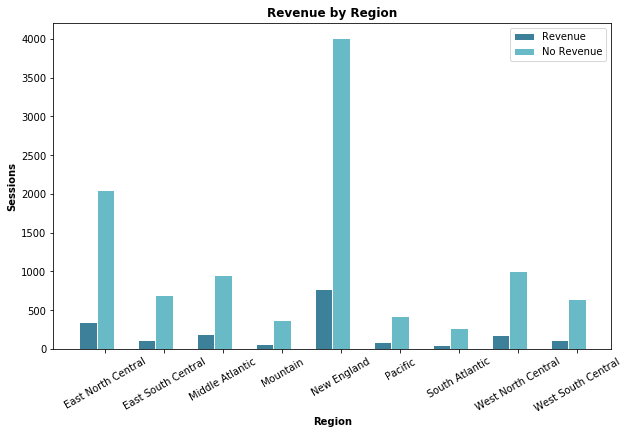

In [18]:
plt.figure(figsize=(10,6))
# set width of bar
barWidth = 0.30
 
# set height of bar
bars1 = regional_revenue[data['Revenue']==True].groupby(['Region']).Revenue.count()
bars2 = regional_revenue[data['Revenue']==False].groupby(['Region']).Revenue.count()
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=sns.color_palette("GnBu_d",n_colors=2)[0],
        width=barWidth, edgecolor='white', label='Revenue')
plt.bar(r2, bars2, color=sns.color_palette("GnBu_d",n_colors=2)[1],
        width=barWidth, edgecolor='white', label='No Revenue')
 
# Add xticks on the middle of the group bars
plt.xlabel('Region', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           regional_revenue[data['Revenue']==True].groupby(['Region']).Revenue.count().index)
plt.xticks(rotation='30')
plt.ylabel('Sessions', fontweight='bold')
plt.title('Revenue by Region', fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()


In [19]:
regional_revenue.groupby(['Region']).Revenue.count()

Region
East North Central    2403
East South Central     805
Middle Atlantic       1136
Mountain               434
New England           4780
Pacific                511
South Atlantic         318
West North Central    1182
West South Central     761
Name: Revenue, dtype: int64

Most of the revenue generationg sessions come generally from the northeast regions of the US. Again, it is imperative to conduct market research to find out and identify the key to successfull sales in the northeast and how to replicate them in other regions.

### 3.3 Average Session Duration

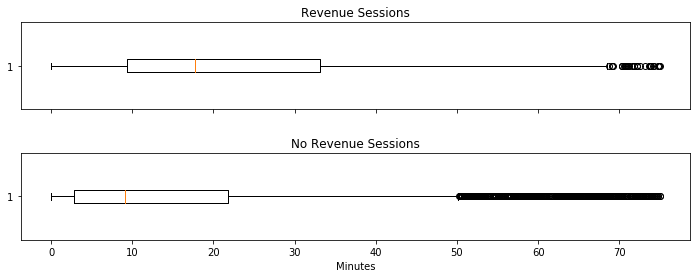

Average Time Spent by Revenue Session:  34.22
Average Time Spent by Non-Revenue Session:  19.57


In [20]:
total_duration = data[['Administrative_Duration','Informational_Duration', 'ProductRelated_Duration','Revenue']]
total_duration['total_duration_mins'] = ((total_duration['Administrative_Duration']+
                                    total_duration['Informational_Duration']+
                                    total_duration['ProductRelated_Duration'])/60)
total_duration_t = total_duration[total_duration['Revenue']==True]
total_duration_f = total_duration[total_duration['Revenue']==False]
#boxplot bedrooms and bathrooms to check for outliers.
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,4), sharex=True)
ax1.boxplot(total_duration_t[total_duration_t['total_duration_mins']<75].total_duration_mins, vert=False)
ax2.boxplot(total_duration_f[total_duration_f['total_duration_mins']<75].total_duration_mins,vert=False)
ax1.set_title('Revenue Sessions')
ax2.set_title('No Revenue Sessions')
plt.subplots_adjust(hspace=0.50)
plt.xlabel('Minutes')
plt.show()
print('Average Time Spent by Revenue Session: ',round(total_duration_t['total_duration_mins'].mean(),2))
print('Average Time Spent by Non-Revenue Session: ',round(total_duration_f['total_duration_mins'].mean(),2))

On average, revenue generating users spend almost double the time than non-revenue generating users on the website. The website is not driving impulse sales but rather well-informed ones. The user seeks as much information as possible about the products he is trying to buy before making the purchase. The information displayed on the website should be easy to find and relevant for the users in orther to drive sales up, but an effort should be made to reduce the time the revenue generating users spend before acquiring a product.

### 3.4 Pages Visited during the Sessions

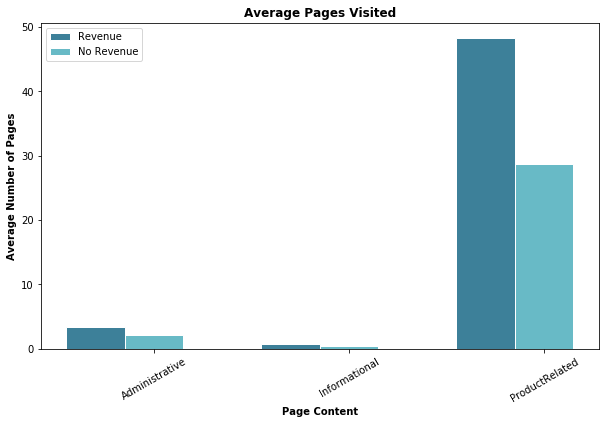

In [21]:
pages = data[['Administrative','Informational', 'ProductRelated','Revenue']].groupby('Revenue').mean()
plt.figure(figsize=(10,6))
# set width of bar
barWidth = 0.30
 
# set height of bar
bars1 = pages.iloc[1]
bars2 = pages.iloc[0]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=sns.color_palette("GnBu_d",n_colors=2)[0],
        width=barWidth, edgecolor='white', label='Revenue')
plt.bar(r2, bars2, color=sns.color_palette("GnBu_d",n_colors=2)[1],
        width=barWidth, edgecolor='white', label='No Revenue')
 
# Add xticks on the middle of the group bars
plt.xlabel('Page Content', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           pages.iloc[0].index)
plt.xticks(rotation='30')
plt.ylabel('Average Number of Pages', fontweight='bold')
plt.title('Average Pages Visited', fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()

It is evident that the most visited pages during any given session are Product Related. The user is driving his decisions based on the contect of the product related pages. From the graph, I also notice that the gap between revenue generating and non-revenue generating sessions is greater than for the other types of pages. Hence, it is important to revise each of those pages for quality content. Now, it is time to pre-process the data based on these findings. 

## 4 Data Pre-processing and Feature Engineering
During the initial EDA I found out some variables that seemed to be numerical turned out they are better used as categorical variables. So far I have identified the following numerical features, either discrete or continuous: 'Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', and 'PageValues'. The remaining columns are to be treated as categorical features, which are: 'Month', 'OperatingSystems', 'Region', 'Revenue', 'SpecialDay', 'TrafficType', 'VisitorType', and 'Weekend'. The target variable of the dataset is 'Revenue'.

I will start by identifying the numerical and categorical feature names.

### 4.1 One-hot-code categorical features

In [22]:
#Create list with categorical features' names.
nonum_feats_names = ['Month', 'OperatingSystems', 'Region', 'Revenue', 
      'SpecialDay', 'TrafficType', 'VisitorType', 'Weekend']

#Create list with numerical features' names.
num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates','PageValues']

In [23]:
#Assign appropriate data type to categorical variables.
nonum_feats = data[nonum_feats_names].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 8 columns):
Month               12330 non-null category
OperatingSystems    12330 non-null category
Region              12330 non-null category
Revenue             12330 non-null category
SpecialDay          12330 non-null category
TrafficType         12330 non-null category
VisitorType         12330 non-null category
Weekend             12330 non-null category
dtypes: category(8)
memory usage: 98.8 KB


In [24]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 52 columns):
Month_Dec                        12330 non-null uint8
Month_Feb                        12330 non-null uint8
Month_Jul                        12330 non-null uint8
Month_June                       12330 non-null uint8
Month_Mar                        12330 non-null uint8
Month_May                        12330 non-null uint8
Month_Nov                        12330 non-null uint8
Month_Oct                        12330 non-null uint8
Month_Sep                        12330 non-null uint8
OperatingSystems_2               12330 non-null uint8
OperatingSystems_3               12330 non-null uint8
OperatingSystems_4               12330 non-null uint8
OperatingSystems_5               12330 non-null uint8
OperatingSystems_6               12330 non-null uint8
OperatingSystems_7               12330 non-null uint8
OperatingSystems_8               12330 non-null uint8
Region_2                   

Now, the categorical columns have gone up to 52 including the target variable which is going to be separated. Now that all variables are numerical, I want to test plain vanilla baseline models in the raw data to see how well they perform on data with very little pre-processing. In this case, all i have done is one hot code the categorical variables, but no transformations have been performed to the numercial features.

### 4.2 Plain Vanilla Classification Models

The classifiers that I will be testing are:
* Logistic Regression
+ Decision Tree
* Random Forest
* Gradient Boosting

In [25]:
ohc_data = pd.concat([data[num_cols_names], ohc_feats.drop('Revenue_True', axis=1)],axis=1)
target = ohc_feats.Revenue_True
results1 = baseline_models(data=[ohc_data,target], verbose=True)

Classification Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2592
           1       0.53      0.54      0.53       491

   micro avg       0.85      0.85      0.85      3083
   macro avg       0.72      0.72      0.72      3083
weighted avg       0.85      0.85      0.85      3083
 

Classification Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

       

In [26]:
#Display the results of the models as a dataframe
#Sort models according to f1 score.
results1.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.622807,0.762778,0.888420,0.674584,0.578411
RandomForest,0.565380,0.714764,0.886799,0.727564,0.462322
DecisionTree,0.530777,0.722103,0.849173,0.526000,0.535642
LogisticRegression,0.501333,0.677750,0.878690,0.725869,0.382892


In [27]:
print('Best Model per Metric')
for metric in results1.columns:
    print(f'{metric.capitalize()}:',results1.sort_values(metric,ascending=False).index[0])

Best Model per Metric
F1: Gradient Boosting
Roc_auc: Gradient Boosting
Accuracy: Gradient Boosting
Precision: RandomForest
Recall: Gradient Boosting


The Gradient Boosting Classifier is the best performing so far. Being this a binary classification problem with an imbalanced dataset, I am mostly concerned with the f1 and roc_auc scores. The f1 score is the harmonic mean between precision and recall, while the roc_auc score is the area under the roc curve from the predicted values. It is important to distiguish between both categories since marketing strategies could  be costly if not applied correctly to the users.

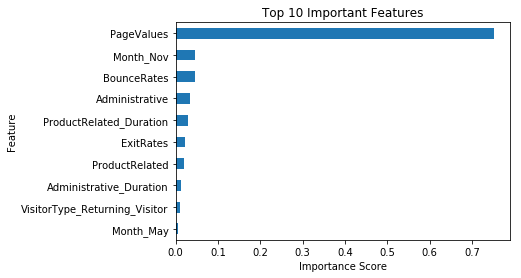

In [28]:
X_train, X_test, y_train, y_test = train_test_split(ohc_data,target,random_state=123)
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
plot_feat_importance(clf, ohc_data.columns)

It is evident form the grah the disproportionate importance of the PageValues feature. However, this was predictable since the page values are directly proportional to the outcome. The higher the value means that they resulted in revenue from the session. This was a very interesting excercie since this is the benchmark for the subsequent pre-processing and data transformation techniques, since teh aim is to keep imporving the models.Let's continue to see if there is any multicolinearity in the data.

### 4.3 Multicolinearity

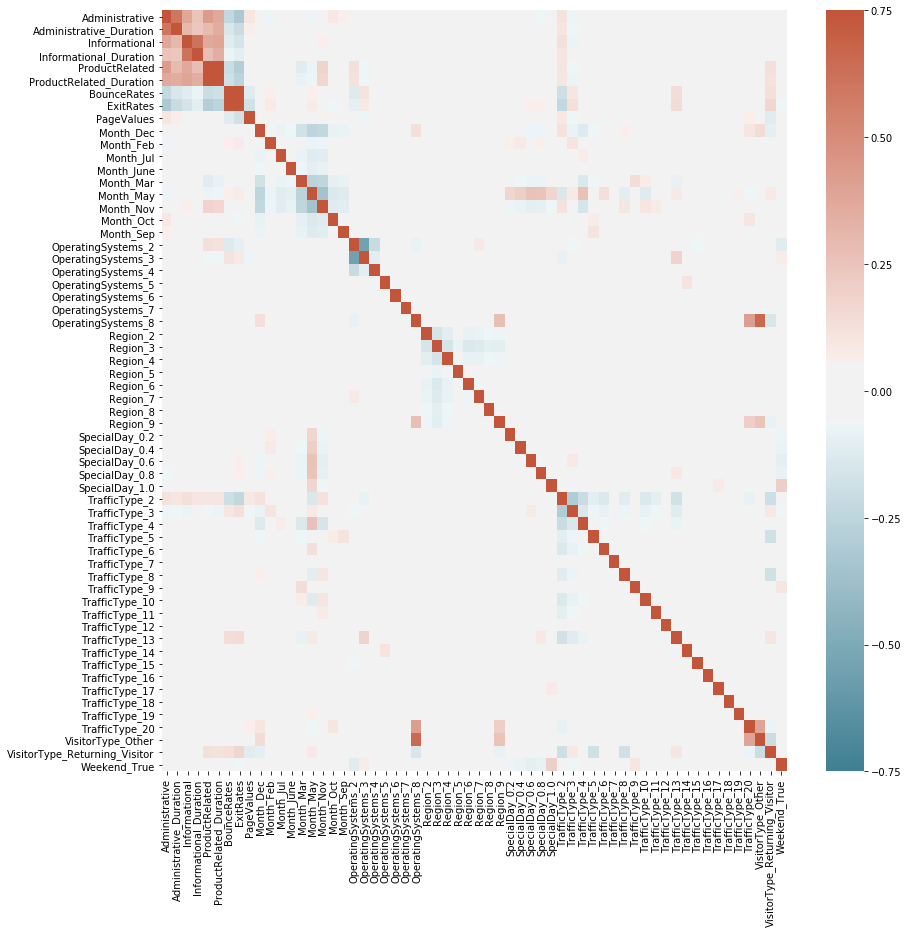

In [29]:
heatmap(ohc_data,figsize=(14,14))

There is not much multicolinearity in the data except for the numerical values excluding PageValues.  Let's look closer into them.

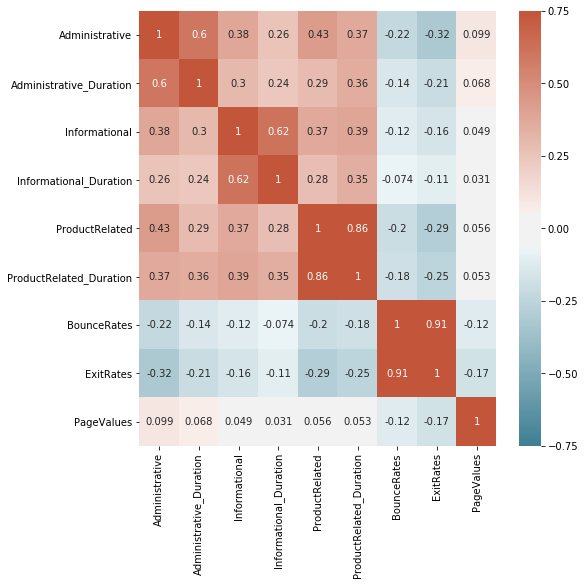

In [30]:
heatmap(ohc_data[num_cols_names],figsize=(8,8), annot=True);

Now that the heatmap only shows the numerical features, it is easier to the the multicolinerity amongst the variables. The highest correlated are:

* Exit Rates and Bounce Rates
* Administrative and Administrative_Duration
* Informational and Informational_Duration
* ProductRelated and ProductRelated_Duration

In regards to bounce and exit rates, a bounce occurs whenever a user enters the page and subsequently exits without visiting another page on the website or interacting with any of the elements on the page. On the other hand, exit rate looks at the number of people who exit your website after landing on a page and compares it to the total number of views the page received. Looking at the importance features derived from the vanilla gradint boosting classifier, I will keep BounceRates and delete ExitRates. 

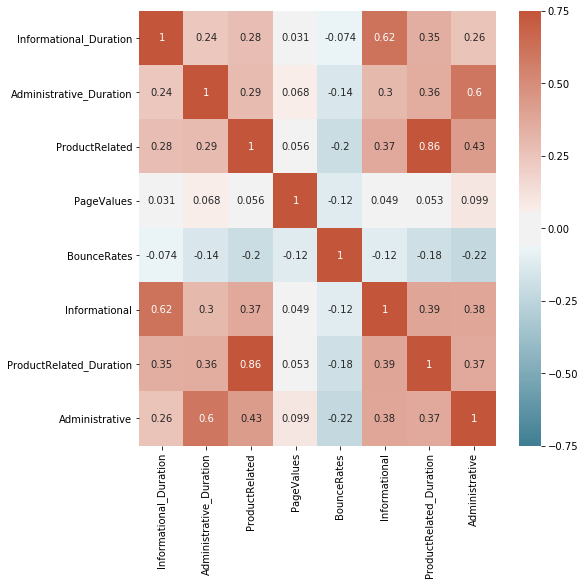

In [31]:
#ohc_data.drop('ExitRates',axis=1,inplace=True)
num_cols_names = list(set(num_cols_names)-set(['ExitRates']))
heatmap(ohc_data[num_cols_names],figsize=(8,8), annot=True);

In regards to the correlation between the pages visited and the duration, I will only look at the one corresponding to informational webpages becuase it exceed my multicolinearity threshold of having a correlation above or below 0.75. I will start by looking at the relationship held amongst them. 

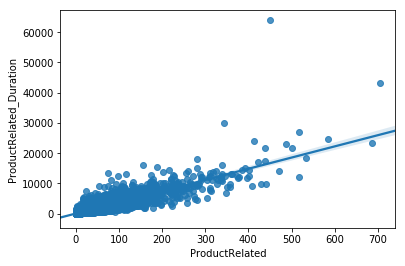

In [32]:
sns.regplot(ohc_data.ProductRelated, ohc_data.ProductRelated_Duration);

From the scatterplot, it is noticed the linear relationship amongts both variables. It makes sense because the more pages the user sees, it is expected to take more time. However to keep multicolinearity low, one feature must be eliminated from the data set, but I still want to keep some of the information. Hence,  I will engineer one feature to measure the time spent per product related page. This feature will take the place of ProductRelated_Duration.

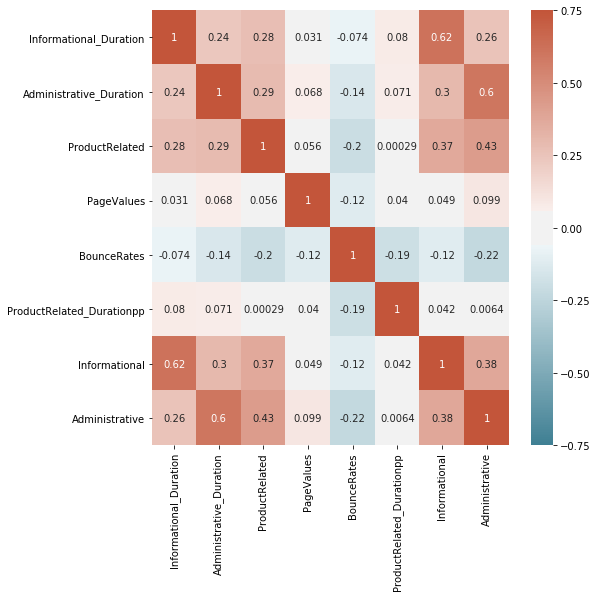

In [33]:
ohc_data['ProductRelated_Durationpp'] = ohc_data.ProductRelated_Duration/ohc_data.ProductRelated
ohc_data = ohc_data.drop('ProductRelated_Duration',axis=1)
ohc_data.ProductRelated_Durationpp.fillna(0,inplace=True)
num_cols_names.append('ProductRelated_Durationpp')
num_cols_names = list(set(num_cols_names)-set(['ProductRelated_Duration']))
heatmap(ohc_data[num_cols_names],figsize=(8,8), annot=True);

It seems that multicolinearity is no longer an issue in the data set. And now, all is left regarding data transformation is scaling the data. However, befor doing that, let's take a look if the vaniall models improved their f1 score.

In [34]:
results2 = baseline_models(data=[ohc_data,target])
results2.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.625551,0.763550,0.889718,0.681055,0.578411
RandomForest,0.551461,0.705738,0.885501,0.733108,0.441955
DecisionTree,0.527806,0.720067,0.848524,0.524096,0.531568
LogisticRegression,0.504673,0.679154,0.879663,0.732558,0.384929


I managed to improve the f1 score of the gradient boosting model. Even if it was just marginally, the real benefit is in not having multicolinearity in the data that will result in more robust ending models. As I finish to pre process the data, I will split the data to be able to standardize the numerical features and perform Synthetic Minority Over-sampling Technique (SMOTE) to correct for the imbalanced target incidence.

In [35]:
#Create a final dataframe with all numerical variables in the first columns.
final_df = pd.concat([ohc_data[num_cols_names],ohc_feats.drop('Revenue_True', axis=1)],axis=1)
#Create final train and test sets startified according to the target variable. 
X_train, X_test, y_train, y_test = train_test_split(final_df,target, test_size = 0.30,stratify=target, 
                                                    random_state=123)

In [36]:
'''Scaling the data first fitting it and transforming the training set
to later aply the fit to transform the test set.'''
#Instantiate Satandard Scaler
scaler = StandardScaler()
#Fit transform the numerical features in the training dataset to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(X_train[num_cols_names]), 
                                     columns=num_cols_names, index= X_train.index)
#Integrate scaled values to the training set
for col in num_cols_names:
    X_train[col] = scaled_numfeats_train[col]
#Transform the numerical features inthe training dataset to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(X_test[num_cols_names]),
                                    columns=num_cols_names, index= X_test.index)
#Integrate scaled values to the test set
for col in num_cols_names:
    X_test[col] = scaled_numfeats_test[col]

In [37]:
results3 = baseline_models(data=[X_train, X_test, y_train, y_test])
results3.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.669187,0.788334,0.905380,0.728395,0.618881
RandomForest,0.591815,0.730674,0.894836,0.740157,0.493007
DecisionTree,0.569957,0.748476,0.864558,0.559865,0.580420
LogisticRegression,0.520270,0.688332,0.884834,0.731013,0.403846


The f1 scores of the baseline models improved by scaling the data. Especifically, gradient boosting saw the greatest performance increase from a little less than 63% to 67%. Now, in an effort to correct the imbalanced dataset I wil perform Synthetic Minority Over-sampling Technique to create synthetic data that helps the model balance the target incidence. 

In [38]:
cat_col_index = list(range(len(num_cols_names),59))
sm = SMOTENC(categorical_features=cat_col_index, random_state=123, sampling_strategy=.6)
X_trainres, y_trainres = sm.fit_resample(X_train, y_train)

In [39]:
#Find out the new target incidency rate.
pd.DataFrame(y_trainres,columns=['outcome']).outcome.value_counts(normalize=True)

0    0.625
1    0.375
Name: outcome, dtype: float64

In [40]:
results4 = baseline_models(data=[X_trainres, X_test, y_trainres, y_test])
results4.sort_values('f1',ascending=False)

,f1,roc_auc,accuracy,precision,recall
Gradient Boosting,0.682625,0.841432,0.888889,0.611342,0.772727
RandomForest,0.633646,0.787844,0.884023,0.619366,0.648601
LogisticRegression,0.576441,0.756802,0.862936,0.552000,0.603147
DecisionTree,0.565737,0.757868,0.852663,0.519766,0.620629


Pre-processing and feature engineering really helped to improve the models ingeneral. The key takeaway is that this transformations will help create more robut model on he hyperparameter tunning section. For now, I managed to go form an f1 score of 62% to 68% and from an roc_auc score of 76% to a little abive of 84%, which both are meaningful increases. The best performing model so far is Gradient Boosting.

Before jumping into tunning the models, I will lokk into rincipal component analysis (PCA) to reduce linear dimensionality of the data and helping the models process the information faster. First I will plot the the PCA spectrum ti find the optimal range of n_estimators that capture the most variance in the data. after that I will create a pipeline with GridSearch for each of the models beign tested.

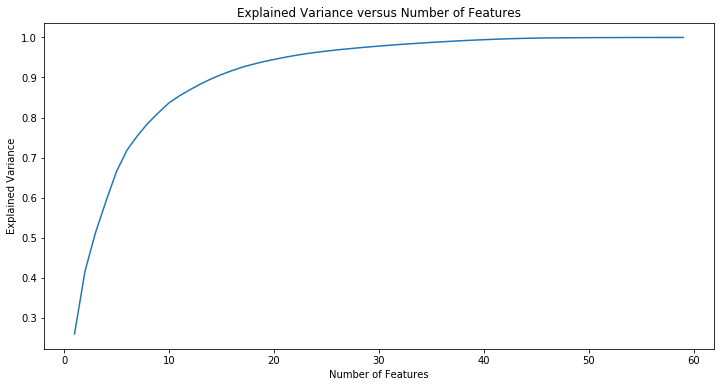

In [41]:
#Instantiate Principal Component Analysis.
pca=PCA()
X_pca = pca.fit_transform(X_trainres)
fig = plt.figure(figsize=(12,6))
plt.plot(range(1,X_trainres.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance versus Number of Features')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Features')
plt.show();

In [42]:
for n in [10,15,20,25]:
    pca_n = PCA(n_components=n)
    X_pcan = pca_n.fit_transform(X_trainres)
    tev = round(np.sum(pca_n.explained_variance_ratio_)*100,2)
    print('Number of Fetaures: ',n, 'Total Explained Variance: ',tev,'%')

Number of Fetaures:  10 Total Explained Variance:  83.65 %
Number of Fetaures:  15 Total Explained Variance:  90.74 %
Number of Fetaures:  20 Total Explained Variance:  94.5 %
Number of Fetaures:  25 Total Explained Variance:  96.59 %


From this graph I notice that the total explained variace starts to increase at a diminishing rate at around n_components=15. It also reduces dimensionality by a fourth of the size with just above 90% of the total variance explained. I would like the pipelines to try with n_components of 15,20,and 25.

## 5. Classification Models

Now that the data is prepped for modelling I will start by creating pipelines with grid search to tune the hyperparameters of each of the models. 

In [43]:
#Create pipeline for each of the classifiers.
pipelines = {'logisticregression': Pipeline([('pca', PCA()),
                                            ('clf', LogisticRegression(random_state=123))]),
            'decisiontree':Pipeline([('pca', PCA()),
                                            ('clf', DecisionTreeClassifier(random_state=123))]),
            'randomforest':Pipeline([('pca', PCA()),
                                            ('clf', RandomForestClassifier(random_state=123))]),
            'gradientboosting': Pipeline([('pca', PCA()),
                                            ('clf', GradientBoostingClassifier(random_state=123))])}

#Define Hyperparameters for each pipeline
hyperparameters_lr ={'pca__n_components': [15, 20, 25],
                     'clf__C': [0.01,0.1,1]}

hyperparameters_dt ={'pca__n_components': [10, 15, 20],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [4, 5, 6],  
                     'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'clf__min_samples_split':[0.05 ,0.1, 0.2]}

hyperparameters_rf ={'pca__n_components': [10, 15, 20],
                     'clf__n_estimators': [100,150],
                     'clf__criterion': ['entropy', 'gini'], 
                     'clf__max_depth': [4, 5, 6],  
                     'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
                     'clf__min_samples_split':[0.05 ,0.1, 0.2]}

hyperparameters_gb ={'pca__n_components': [10, 15, 20],
                     'clf__n_estimators': [100,150], 
                     'clf__max_depth': [1, 3, 5],  
                     'clf__learning_rate': [0.05,0.1]}

#Instantiate hyperparapeter dictionary
hyperparameters = {'logisticregression':hyperparameters_lr ,
                   'decisiontree':hyperparameters_dt,
                   'randomforest':hyperparameters_rf,
                   'gradientboosting': hyperparameters_gb}

In [44]:
model_scores_auc, fitted_models_auc = grid_pipe(pipelines,hyperparameters,scoring='roc_auc')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


The logisticregression model has been fitted.
Best accuracy: 0.914
Best params:
 {'clf__C': 0.01, 'pca__n_components': 25} 

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   34.9s finished


The decisiontree model has been fitted.
Best accuracy: 0.900
Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.1, 'pca__n_components': 20} 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  6.8min finished


The randomforest model has been fitted.
Best accuracy: 0.916
Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 150, 'pca__n_components': 20} 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.6min finished


The gradientboosting model has been fitted.
Best accuracy: 0.950
Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150, 'pca__n_components': 20} 



In [45]:
score_times_df_auc = pd.DataFrame(model_scores_auc,
                              columns=['classifier','roc_auc_score',
                                       'time']).set_index('classifier').sort_values('time')
score_times_df_auc

,roc_auc_score,time
classifier,,
logisticregression,0.913990,3.630053
decisiontree,0.900376,35.135651
gradientboosting,0.950411,99.835336
randomforest,0.915789,407.977265


The best performing classifier is gradient boosting with almost 95% roc_auc score. It is expected that ensemble models perform better than single classifiers. However, this comes at greater computational cost. The second best performing model is also an ensemble model, random forest, but given it almost identical score to logistic regression and that it took close to 100 times more time to fit, I consider the second best model to be logistic regression.

logisticregression :


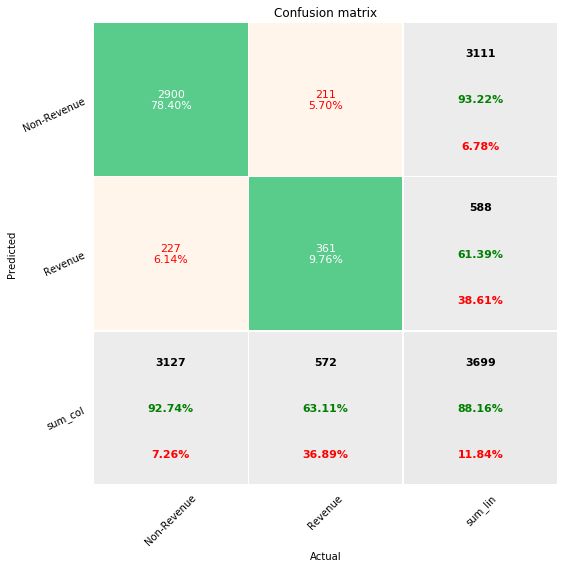

gradientboosting :


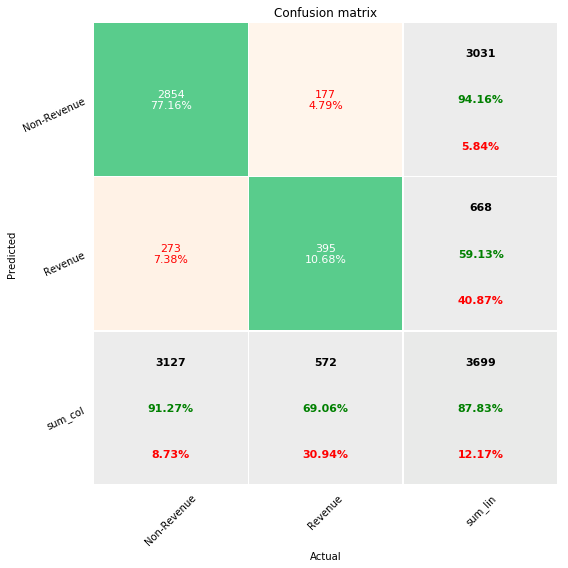

In [155]:
for name, model in fitted_models_auc.items():
    if name in ['logisticregression','gradientboosting']:
        pred = model.predict(X_test)
        print(name,':')
        plot_confusion_matrix_from_data(y_test,pred, columns=['Non-Revenue','Revenue'], cmap='Oranges')

In [47]:
model_scores_f1, fitted_models_f1 = grid_pipe(pipelines,hyperparameters,scoring='f1')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


The logisticregression model has been fitted.
Best accuracy: 0.758
Best params:
 {'clf__C': 0.1, 'pca__n_components': 25} 

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   28.4s finished


The decisiontree model has been fitted.
Best accuracy: 0.779
Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.1, 'pca__n_components': 20} 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  6.5min finished


The randomforest model has been fitted.
Best accuracy: 0.753
Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.1, 'clf__n_estimators': 100, 'pca__n_components': 20} 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.5min finished


The gradientboosting model has been fitted.
Best accuracy: 0.843
Best params:
 {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150, 'pca__n_components': 20} 



In [48]:
score_times_df_f1 = pd.DataFrame(model_scores_f1,
                              columns=['classifier','f1_score',
                                       'time']).set_index('classifier').sort_values('time')
score_times_df_f1

,f1_score,time
classifier,,
logisticregression,0.757732,1.863697
decisiontree,0.779479,28.615513
gradientboosting,0.843433,98.384208
randomforest,0.753252,392.494935


logisticregression :


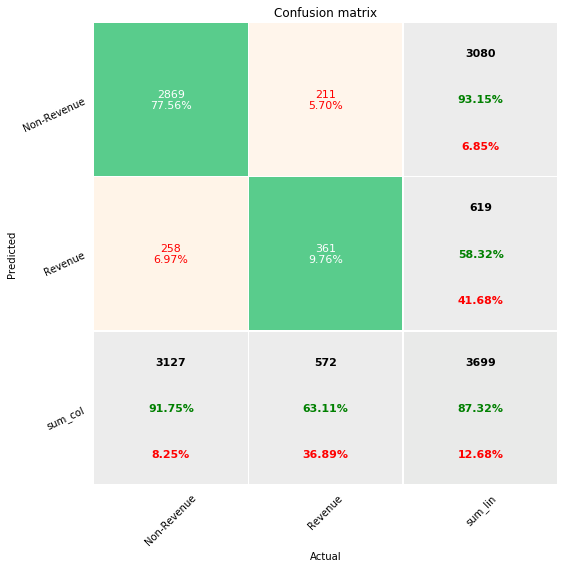

gradientboosting :


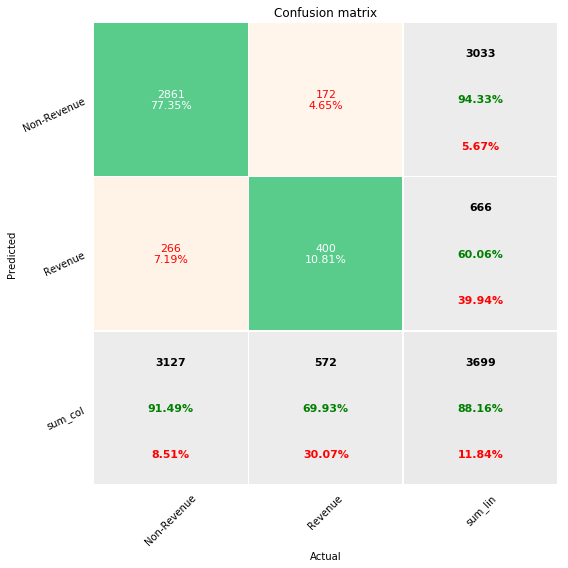

In [156]:
for name, model in fitted_models_f1.items():
    if name in ['logisticregression','gradientboosting']:
        pred = model.predict(X_test)
        print(name,':')
        plot_confusion_matrix_from_data(y_test,pred,columns=['Non-Revenue','Revenue'], cmap='Oranges')

In [50]:
fitted_models_f1['gradientboosting'].best_params_

{'clf__learning_rate': 0.1,
 'clf__max_depth': 5,
 'clf__n_estimators': 150,
 'pca__n_components': 20}

## 6. Conclusion and Recommendations
At first, I looked into the f1 score in order to improve the balnce of the imbalanced dataset. I checked for multicolinearity and delt with high correletaion features accordingly. The f1 score increase by about 6% and the roc_auc score by 8% just through scrubbing the data.

Once the data was ready to enter the pipelines to perform hyperparameter tuning, I conducted principal component analysis to derive the best n_component values to pass on to the pipelines. Turns out the with n_components =25 the data contains a little over 96% of the total explained variance, with half the number of total features. And, with n_components =15, the dataset contains over 90% of the total explained variance. So, decided to imput values in that range.

After running the grid search pipeline, the two best performing models are gradient boosting and logistic regression. Gradient boosting surpasses logistic regression in every metric, except running time. Hence, it will be important to consider the trade-off between computational cost and time.

In , my opinion, I recommend to test the Gradient Boosting Classifier in server conditions. If the model takes a long time to make the classiification, then Logistic Regression is preferred. Identification of the class of session as the user navigates the website has to be immediate in order to deploy marketing tactics that incentivize revenue generating behaviour being carefull not to be a deterrant. If the user is exhibiting favorable behaviour there is no need for aggresive tactics that could scare him.

In [51]:
score_times_df_f1.loc[['gradientboosting','logisticregression']]

,f1_score,time
classifier,,
gradientboosting,0.843433,98.384208
logisticregression,0.757732,1.863697


In [52]:
score_times_df_auc.loc[['gradientboosting','logisticregression']]

,roc_auc_score,time
classifier,,
gradientboosting,0.950411,99.835336
logisticregression,0.913990,3.630053


## 7 Further Work
In order to keep improving the model, this are the following actionable steps:
+ Try a different SMOTE sampling startegy that resust in a different target incidency.
+ Create duartion per pago for Administrative and Informative related pages.
+ Create a new pipeline with only logistic regressor and gradient boosting classifier and try other different parameters that approximate the pipe's resulting best parameters.

## 8. Bibliography and References
* Dataset: Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). https://link.springer.com/article/10.1007%2Fs00521-018-3523-0